In [104]:
import pandas as pd 
import numpy as np 
import re
from openai import OpenAI
import ast
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, pearsonr
import pickle
import itertools
from sklearn.manifold import TSNE
import plotly.express as px
import textwrap
from sklearn.decomposition import PCA
client = OpenAI(api_key=open("/Users/mosobay/Dropbox (MIT)/research/openai_api", "r").read().strip())

In [64]:
df_llm = pd.read_csv("../data/consolidated_dimensions.csv")
df_llm = pd.concat([df_llm.query("source == @x").drop_duplicates(["dim_name"]) for x in df_llm["source"].unique()], ignore_index=True)
df_expert = pd.read_csv("../data/24_dimensions_clean.csv").assign(Source = "literature")
df_expert.columns = ["dim_name", "dim_desc", "source"]

df = pd.concat([df_llm, df_expert], ignore_index=True)
df["embed_text"] = df["dim_name"] + ": " + df["dim_desc"]

In [78]:
regex_string = "[0-9]|[.,!?;]|Type"
df["cleansed_embed_text"] = [re.sub(regex_string, "", x).strip() for x in df["embed_text"]]

In [79]:
embeddings = client.embeddings.create(
        model="text-embedding-ada-002",
        input=df["cleansed_embed_text"].to_list(),
        encoding_format="float"
    )

df["embedding"] = [x.embedding for x in embeddings.data]

In [115]:
tsne = TSNE(n_components=2, random_state=2024)
pca = PCA(n_components=2)
df[["tsne_1", "tsne_2"]] = tsne.fit_transform(np.array(df["embedding"].tolist()))
df[["pca_1", "pca_2"]] = pca.fit_transform(np.array(df["embedding"].tolist()))

In [116]:
def wrap_hovertext(hovertext, width=20):
    wrapped_hovertext = ["<br>".join(textwrap.wrap(text,width=width)) for text in hovertext]
    return wrapped_hovertext  

In [117]:
df["dim_desc_wrapped"] = wrap_hovertext(df["dim_desc"])

In [118]:
# df.to_pickle("consolidated_dims_w_embeddings.pkl")

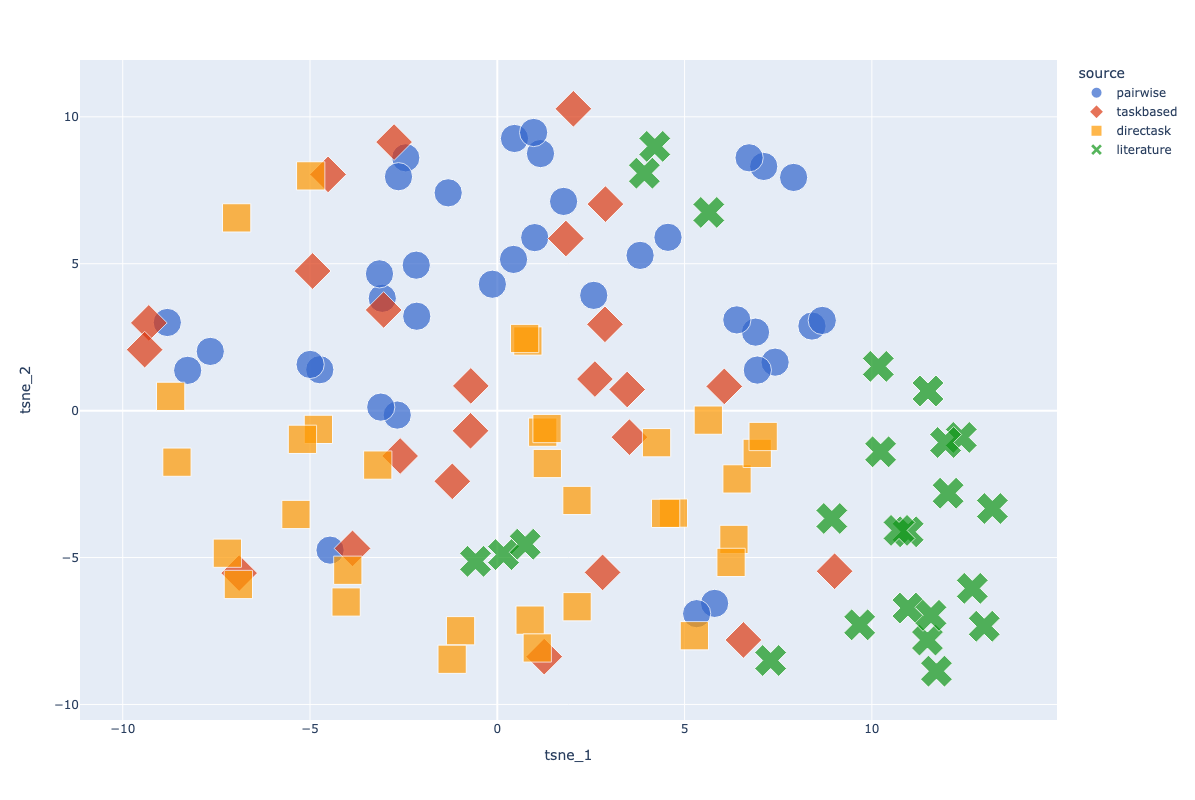

In [119]:
px.scatter(x="tsne_1", y="tsne_2", data_frame=df, color="source", hover_name="dim_name", height=800, width=800,
          color_discrete_sequence=px.colors.qualitative.G10, symbol="source", size=[0.4]*len(df), hover_data="dim_desc_wrapped")

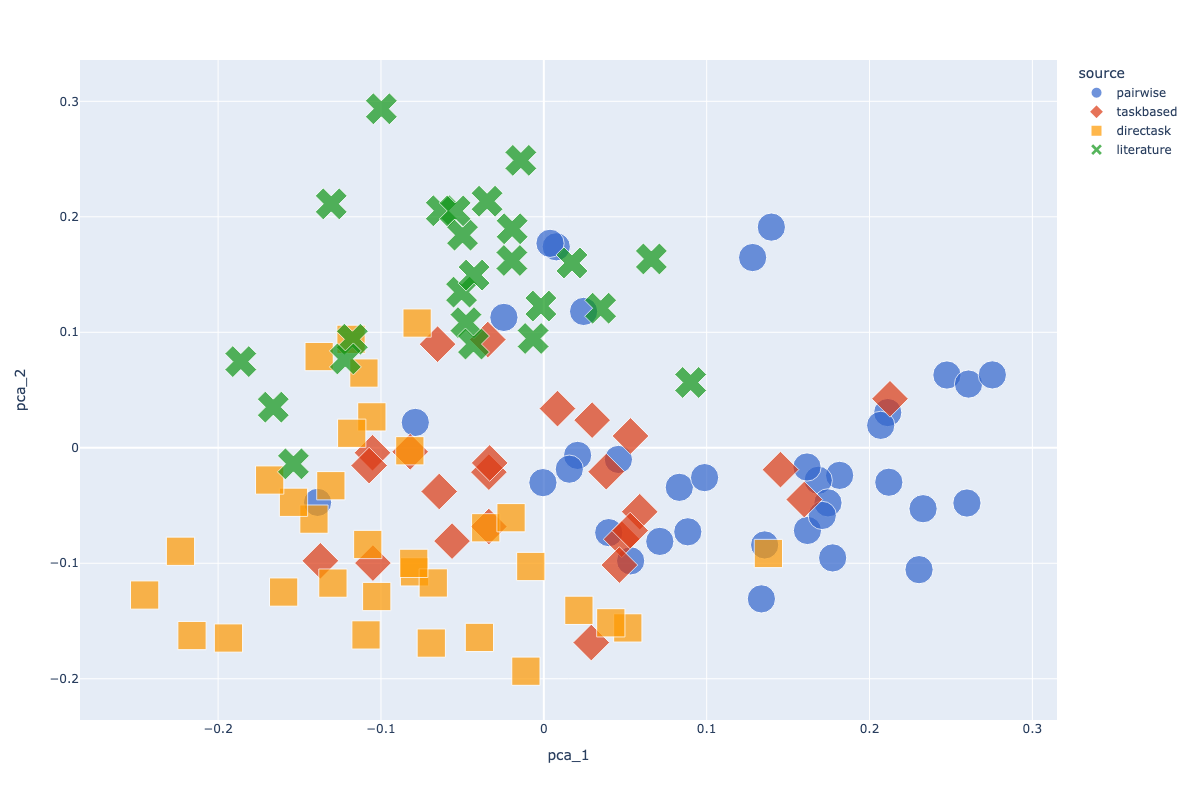

In [106]:
px.scatter(x="pca_1", y="pca_2", data_frame=df, color="source", hover_name="dim_name", height=800, width=800,
          color_discrete_sequence=px.colors.qualitative.G10, symbol="source", size=[0.4]*len(df), hover_data="dim_desc_wrapped")

In [42]:
df.shape

(110, 7)